<a href="https://colab.research.google.com/github/chiranjeet14/ML_Projects/blob/master/Competition/Health_Insurance_Lead_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import io

# settings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Additional packages
# !pip3 install category_encoders > /dev/null
!pip3 install pandas_profiling > /dev/null
!pip3 install imbalanced-learn > /dev/null
!pip3 install xgboost > /dev/null

In [ ]:
!mkdir -p /home/jovyan/work/dataset
!touch /home/jovyan/work/dataset/train-file.csv
!touch /home/jovyan/work/dataset/test-file.csv

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
# Calculating Precision, Recall and f1-score
def model_score(actual_value,predicted_values):
  from sklearn.metrics import confusion_matrix 
  from sklearn.metrics import accuracy_score 
  from sklearn.metrics import classification_report 
  from sklearn.metrics import recall_score
  from sklearn.metrics import roc_auc_score
  
  actual = actual_value
  predicted = predicted_values
  results = confusion_matrix(actual, predicted) 
  
  print('Confusion Matrix :')
  print(results) 
  print('Accuracy Score :',accuracy_score(actual, predicted))
  print('Report : ')
  print(classification_report(actual, predicted))
  print('Recall Score : ')
  print(recall_score(actual, predicted))
  print('ROC AUC Score : ')
  print(roc_auc_score(actual, predicted))

In [ ]:
train_file_id = '1g4fy7o25PMf9veOyuiVdNIAyjfDGPT-N'
test_file_id = '1fc0iGQHsS6oG4ARZCdlz1b_jFkOJWyqQ'
train_destination = '/home/jovyan/work/dataset/train-file.csv'
test_destination = '/home/jovyan/work/dataset/test-file.csv'
download_file_from_google_drive(train_file_id, train_destination)
download_file_from_google_drive(test_file_id, test_destination)

In [ ]:
df_train = pd.read_csv('/home/jovyan/work/dataset/train-file.csv')
df_test = pd.read_csv('/home/jovyan/work/dataset/test-file.csv')
df_train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [ ]:
# from pandas_profiling import ProfileReport
# report = ProfileReport(df_train, title='Pandas Profiling Report', explorative=True)
# report

In [ ]:
df_train.isnull().any()

ID                         False
City_Code                  False
Region_Code                False
Accomodation_Type          False
Reco_Insurance_Type        False
Upper_Age                  False
Lower_Age                  False
Is_Spouse                  False
Health Indicator            True
Holding_Policy_Duration     True
Holding_Policy_Type         True
Reco_Policy_Cat            False
Reco_Policy_Premium        False
Response                   False
dtype: bool

Health Indicator has 11691 (23.0%) missing values
Holding_Policy_Duration has 20251 (39.8%) missing values
Holding_Policy_Type has 20251 (39.8%) missing values

Replacing them with a new category

In [ ]:
# df_train[['Health Indicator']] = df_train[['Health Indicator']].cat.add_categories(['X100'])
# df_train[['Holding_Policy_Duration']] = df_train[['Holding_Policy_Duration']].cat.add_categories(['100'])
# df_train[['Holding_Policy_Type']] = df_train[['Holding_Policy_Type']].cat.add_categories(['10'])

df_train['Health Indicator'].fillna('X100', inplace=True)
df_train['Holding_Policy_Duration'].fillna('100', inplace=True)
df_train['Holding_Policy_Type'].fillna('10', inplace=True)

df_test['Health Indicator'].fillna('X100', inplace=True)
df_test['Holding_Policy_Duration'].fillna('100', inplace=True)
df_test['Holding_Policy_Type'].fillna('10', inplace=True)

In [ ]:
# all_columns = ['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator  Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium']

categorical_columns_list = ['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat']
numerical_cloumns_list = ['Upper_Age', 'Lower_Age', 'Reco_Policy_Premium']

### Encoding Categorical Variables

In [ ]:
from sklearn import preprocessing

label_object = {}
categorical_columns = categorical_columns_list
for col in categorical_columns:
    labelencoder = preprocessing.LabelEncoder()
    labelencoder.fit(df_train[col].astype(str))
    df_train[col] = labelencoder.fit_transform(df_train[col].astype(str))
    df_test[col] = labelencoder.fit_transform(df_test[col].astype(str))
    label_object[col] = labelencoder

In [ ]:
# Sample inverse_transform
label_object['City_Code'].inverse_transform(df_train['City_Code'][:5])

array(['C3', 'C5', 'C5', 'C24', 'C8'], dtype=object)

In [ ]:
df_train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,22,2137,1,0,36,36,0,0,6,3,14,11628.0,0
1,2,31,117,0,1,75,22,0,2,2,1,14,30510.0,0
2,3,31,2664,0,0,32,32,0,1,0,0,10,7450.0,1
3,4,16,3322,0,1,52,48,0,0,6,3,10,17780.0,0
4,5,34,1151,1,0,44,44,0,2,9,0,7,10404.0,0


### Checking if the dataset is balanced/imbalanced

Class 0 (No): 38673
Class 1 (Yes): 12209
Proportion: 3.17 : 1


<AxesSubplot:title={'center':'Responses'}>

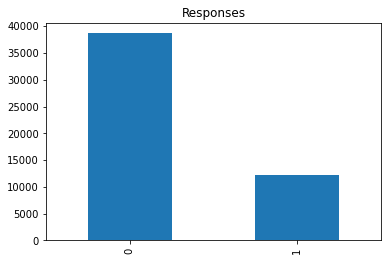

In [ ]:
# python check if dataset is imbalanced : https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

target_count = df_train['Response'].value_counts()
print('Class 0 (No):', target_count[0])
print('Class 1 (Yes):', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Responses')

### Splitting Data into train-cv

In [ ]:
labels = df_train['Response'].values
df_train.drop(['ID','Response'], axis=1, inplace=True)
df_test.drop(['ID','Response'], axis=1, inplace=True, errors='ignore')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(df_train, labels, test_size=0.1, shuffle=False)

In [ ]:
X_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,22,2137,1,0,36,36,0,0,6,3,14,11628.0
1,31,117,0,1,75,22,0,2,2,1,14,30510.0
2,31,2664,0,0,32,32,0,1,0,0,10,7450.0
3,16,3322,0,1,52,48,0,0,6,3,10,17780.0
4,34,1151,1,0,44,44,0,2,9,0,7,10404.0


### Over Sampling using SMOTE

In [ ]:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
from imblearn.over_sampling import SMOTE
smote_overSampling = SMOTE()
X_train,y_train = smote_overSampling.fit_resample(X_train,y_train)
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 34780, 1: 34780}

### Scaling data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(df_test)
X_train_scaled

array([[ 0.62267931, -0.05712771,  1.28326889, ...,  1.20338235,
         0.91943228, -0.38818493],
       [ 1.40726493, -1.25507571, -0.77925991, ..., -0.49930014,
         0.91943228,  2.47336144],
       [ 1.40726493,  0.25540625, -0.77925991, ..., -1.35064138,
         0.01624657, -1.02135624],
       ...,
       [-0.42343486,  0.3840967 , -0.77925991, ...,  0.35204111,
         0.24204299,  0.99643134],
       [-0.59778722, -1.00540437, -0.77925991, ..., -0.49930014,
         0.01624657, -0.5646843 ],
       [-0.16190632, -1.11452438, -0.77925991, ...,  1.20338235,
         0.69363585,  0.23690757]])

### Modelling & Cross-Validation

In [ ]:
%%time
# Train multiple models : https://www.kaggle.com/tflare/testing-multiple-models-with-scikit-learn-0-79425
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit, cross_val_score

models = []

LogisticRegression = LogisticRegression(n_jobs=-1)
LinearSVC = LinearSVC()
KNeighbors = KNeighborsClassifier(n_jobs=-1)
DecisionTree = DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
AdaBoost = AdaBoostClassifier()
Bagging = BaggingClassifier()
ExtraTrees = ExtraTreesClassifier()
GradientBoosting = GradientBoostingClassifier()
LogisticRegressionCV = LogisticRegressionCV(n_jobs=-1)
XGBClassifier = XGBClassifier(nthread=-1)

# models.append(("LogisticRegression",LogisticRegression))
# models.append(("LinearSVC", LinearSVC))
# models.append(("KNeighbors", KNeighbors))
# models.append(("DecisionTree", DecisionTree))
# models.append(("AdaBoost", AdaBoost))
# models.append(("Bagging", Bagging))
# models.append(("ExtraTrees", ExtraTrees))
# models.append(("GradientBoosting", GradientBoosting))
# models.append(("LogisticRegressionCV", LogisticRegressionCV))
models.append(("RandomForest", RandomForest))
# models.append(("XGBClassifier", XGBClassifier))

metric_names = ['f1', 'average_precision', 'accuracy', 'precision', 'recall', 'roc_auc']
# tscv = TimeSeriesSplit(n_splits=5)
results = []
names = []

nested_dict = {}

for name,model in models:
  nested_dict[name] = {}
  for metric in metric_names:
    score = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, scoring=metric, cv=None, verbose=5)
    nested_dict[name][metric] = score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.3s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.4s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_

CPU times: user 268 ms, sys: 125 ms, total: 392 ms
Wall time: 47.8 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished


In [ ]:
import json
print(json.dumps(nested_dict, sort_keys=True, indent=4))

{
    "RandomForest": {
        "accuracy": 0.76154399079931,
        "average_precision": 0.8439460654423595,
        "f1": 0.722507767592605,
        "precision": 0.7753641669159872,
        "recall": 0.7076768257619321,
        "roc_auc": 0.8395994137635366
    }
}


In [ ]:
from pprint import pprint
print("Predicting using RandomForest")
alg = RandomForest
alg.fit(X_train_scaled, y_train)
predictions = alg.predict(X_cv_scaled)
pprint(alg.get_params())

Predicting using RandomForest
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
model_score(y_cv,predictions)

Confusion Matrix :
[[3220  673]
 [ 937  259]]
Accuracy Score : 0.6836313617606602
Report : 
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      3893
           1       0.28      0.22      0.24      1196

    accuracy                           0.68      5089
   macro avg       0.53      0.52      0.52      5089
weighted avg       0.66      0.68      0.67      5089

Recall Score : 
0.2165551839464883
ROC AUC Score : 
0.5218403970079217


### Hyperparameter Tuning

In [ ]:
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Class weight selection method
class_weight = ['balanced', 'balanced_subsample', None]

# Warm start
warm_start = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'warm_start': warm_start,
               'class_weight': class_weight}
pprint(random_grid)

{'bootstrap': [True, False],
 'class_weight': ['balanced', 'balanced_subsample', None],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
rf_random = RandomizedSearchCV(estimator=alg, param_distributions=random_grid, n_iter=50, verbose=5, n_jobs=-1)
rf_random.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                    

In [ ]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'class_weight': None,
 'bootstrap': True}

In [ ]:
predictions = rf_random.predict(X_cv_scaled)
model_score(y_cv,predictions)

Confusion Matrix :
[[3227  666]
 [ 934  262]]
Accuracy Score : 0.6855963843584201
Report : 
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      3893
           1       0.28      0.22      0.25      1196

    accuracy                           0.69      5089
   macro avg       0.53      0.52      0.52      5089
weighted avg       0.66      0.69      0.67      5089

Recall Score : 
0.21906354515050167
ROC AUC Score : 
0.5239936271860908


### Predicting on test Data

In [ ]:
# trained_model = alg
trained_model = rf_random
predictions_trained_model_test = trained_model.predict(X_test_scaled)

In [ ]:
read = pd.read_csv('/home/jovyan/work/dataset/test-file.csv')
submission = pd.DataFrame({
        "ID": read["ID"],
        "Response": predictions_trained_model_test
    })

submission.to_csv('./submission.csv', index=False)

In [ ]:
submission.head()

,ID,Response
0,50883,1
1,50884,0
2,50885,0
3,50886,0
4,50887,0
